In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [12]:
class Value():
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
        self.label = label
        
    def __repr__(self):
        return "Value(data={}, grad={})".format(self.data, self.grad)
    
    def __add__(self, other):
        if not isinstance(other, Value): other = Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        if not isinstance(other, Value): other = Value(other)
        out = Value(other.data + self.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out
    
    def __sub__(self, other):
        if not isinstance(other, Value): other = Value(other)
        out = Value(self.data - other.data, (self, other), '-')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out
    
    def __rsub__(self, other):
        if not isinstance(other, Value): other = Value(other)
        out = Value(other.data - self.data, (self, other), '-')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        if not isinstance(other, Value): other = Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        if not isinstance(other, Value): other = Value(other)
        out = Value(other.data * self.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ) , "tanh")
        
        def _backward():
            self.grad += 1 - (out.data ** 2)
        out._backward = _backward
        
        return out
    
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

In [13]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [14]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
w1 = Value(-3.0, label="w1")
w2= Value(1.0, label="w2")
b = Value(6.8813735870195432, label="b")
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 * x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [15]:
o.grad = 1

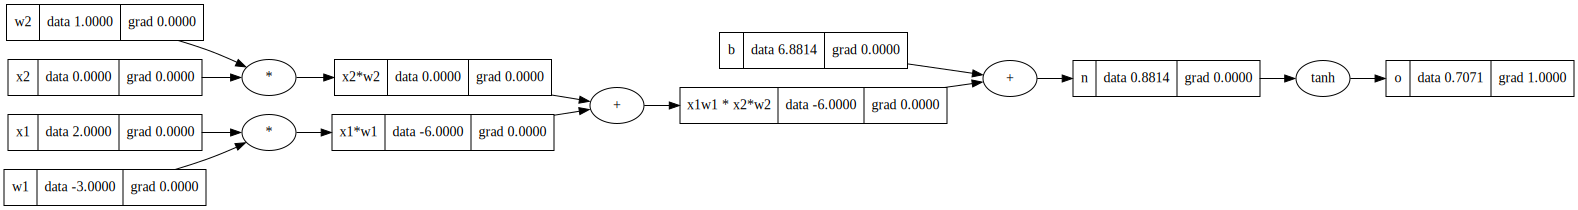

In [16]:
draw_dot(o)

In [134]:
o.backward()

In [337]:
class Neuron:
    
    def __init__(self, nin): # nin is the number of inputs to the neuron
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in (zip(self.w, x))), self.b) + self.b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
    
class MLP:
    
    def __init__(self, nin, nout):
        sz = [nin] + nout
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nout))]
        
    def __call__(self, x):        
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.6878565205049515, grad=0.0)

In [340]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [378]:
ypred = [n(x) for x in xs ]
loss = sum((ygrt - yout)*(ygrt - yout) for ygrt, yout in zip(ys, ypred))
loss

Value(data=5.390174206466142, grad=0.0)

In [379]:
loss.backward()

In [380]:
n.layers[0].neurons[0].w[0].grad

21.348251586544094

In [381]:
n.layers[0].neurons[0].w[0].data

0.5965249767293461

In [382]:
for p in n.parameters():
    p.data += -0.001 * p.grad

In [383]:
ypred

[Value(data=0.13614996221698486, grad=1.7277000755660303),
 Value(data=0.5258430953349292, grad=-3.0516861906698587),
 Value(data=0.49879115780418315, grad=-2.9975823156083665),
 Value(data=0.7366271988318789, grad=0.5267456023362422)]